# Emotion detection for facial expressions

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import pandas as pd
import torch.nn.functional as F
from torch.utils.data import Dataset,DataLoader, random_split
from torchvision import transforms
import torch.optim as optim
from torch import nn
from modules.bcosconv2d import BcosConv2d
torch.manual_seed(123)

# Loading the dataset

In [2]:
df = pd.read_csv('fer2013.csv')

class FER2013Dataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        #Load pixels and labels from csv
        pixels = self.dataframe.iloc[idx, 1]
        label = int(self.dataframe.iloc[idx, 0])

        # Convert to 48x48 pixel image
        image = np.fromstring(pixels, sep=' ').reshape(48, 48).astype(np.uint8)

        if self.transform:
            image = self.transform(image)

        return image, label

# Define transformation
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((48, 48)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# Create dataset
fer_dataset = FER2013Dataset(dataframe=df, transform=transform)

# Split in Training (80%), Validation (10%) and Test (10%)
train_size = int(0.8 * len(fer_dataset))
val_size = int(0.1 * len(fer_dataset))
test_size = len(fer_dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(fer_dataset, [train_size, val_size, test_size])

# Create dataloader
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)



Bilder: torch.Size([32, 1, 48, 48])
Labels: tensor([3, 6, 4, 3, 3, 5, 3, 0, 2, 4, 3, 3, 5, 2, 0, 0, 0, 6, 0, 0, 0, 4, 6, 4,
        6, 6, 3, 0, 6, 3, 5, 5])


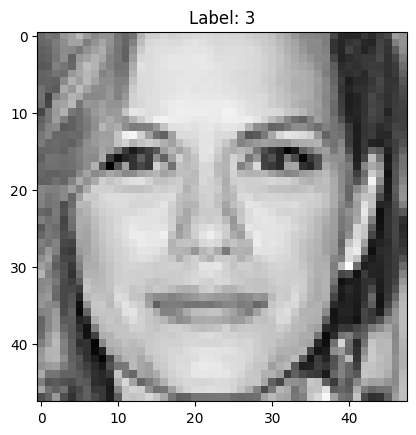

In [3]:
# Example: Load a batch and plot an image
data_iter = iter(train_loader)
images, labels = next(data_iter)

print(f"Bilder: {images.shape}")
print(f"Labels: {labels}")

plt.imshow(images[0].squeeze(), cmap="gray")
plt.title(f"Label: {labels[0].item()}")
plt.show()

## Implementing the network

In [4]:
class SimpleCNN(nn.Module):
    def __init__(self
    ):
        super().__init__()
        
        self.C=7
        # Convolution layers
        self.conv1 = nn.Conv2d(1, 4, kernel_size=(5,5), padding=2)
        self.conv2 = nn.Conv2d(4, 8, kernel_size=(10,10))
        # Fully connected layers
        self.fc1= nn.Linear(392, 120)
        self.fc2=nn.Linear(120,self.C)

    def forward(self, x):
        # x shape: (batch_size, C_in, H, W)
        out=self.conv1(x)
        out=F.relu(out)
        out=F.avg_pool2d(out,kernel_size=2,stride=2)
        out=self.conv2(out)
        out=F.relu(out)
        out=F.avg_pool2d(out,kernel_size=2,stride=2)
        
        #From now on the FC layers
        out = out.view(-1, out.shape[-3]*out.shape[-2]*out.shape[-1])
        
        out =self.fc1(out)
        out = F.relu(out)
        out = self.fc2(out)

        
        return out

In [5]:
class LeNet5(nn.Module):
    def __init__(
        self,
    ):
        super().__init__()
        
        self.C=7
        # Convolution layers
        self.conv1 = nn.Conv2d(1, 6, kernel_size=(5,5), padding=2)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=(10,10))
        # Fully connected layers
        self.fc1= nn.Linear(784, 240)
        self.fc2 = nn.Linear(240, 120)
        self.fc3=nn.Linear(120,self.C)

    def forward(self, x):
        # x shape: (batch_size, C_in, H, W)
        out=self.conv1(x)
        out=F.relu(out)
        out=F.avg_pool2d(out,kernel_size=2,stride=2)
        out=self.conv2(out)
        out=F.relu(out)
        out=F.avg_pool2d(out,kernel_size=2,stride=2)
        
        #From now on the FC layers
        out = out.view(-1, out.shape[-3]*out.shape[-2]*out.shape[-1])
        
        out =self.fc1(out)
        out = F.relu(out)
        out = self.fc2(out)
        out = F.relu(out)
        out = self.fc3(out)
        
        return out

In [6]:
class VGG16(nn.Module):
    def __init__(self, num_classes=7):
        super(VGG16, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU())
        self.layer2 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU())
        self.layer4 = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer5 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU())
        self.layer6 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU())
        self.layer7 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer8 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.layer9 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.layer10 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer11 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.layer12 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.layer13 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(512, 4096),
            nn.ReLU())
        self.fc1 = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU())
        self.fc2= nn.Sequential(
            nn.Linear(4096, num_classes))

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        out = self.layer6(out)
        out = self.layer7(out)
        out = self.layer8(out)
        out = self.layer9(out)
        out = self.layer10(out)
        out = self.layer11(out)
        out = self.layer12(out)
        out = self.layer13(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        out = self.fc1(out)
        out = self.fc2(out)
        return out

In [7]:
class VGG16light(nn.Module):
    def __init__(self, num_classes=7):
        super(VGG16light, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU())
        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer3 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU())
        self.layer4 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer5 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU())
        self.layer6 = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU())
        self.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(18432, 1024),
            nn.ReLU())
        self.fc1 = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(1024, 1024),
            nn.ReLU())
        self.fc2= nn.Sequential(
            nn.Linear(1024, num_classes))

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        out = self.layer6(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        out = self.fc1(out)
        out = self.fc2(out)
        return out

Arnav

In [8]:
class VGG16lightBcos(nn.Module):
    def __init__(self, num_classes=7):
        super(VGG16lightBcos, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU())
        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer3 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU())
        self.layer4 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer5 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU())
        self.layer6 = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU())
        self.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(18432, 1024),
            nn.ReLU())
        self.fc1 = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(1024, 1024),
            nn.ReLU())
        self.fc2= nn.Sequential(
            nn.Linear(1024, num_classes))

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        out = self.layer6(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        out = self.fc1(out)
        out = self.fc2(out)

        # B-cos layer
        scale = torch.norm(out, p=2, dim=1, keepdim=True)
        out = out / scale

        return out

In [9]:
# Training and validation loop with cosine similarity
def train(model, train_loader, val_loader, epochs, optimizer, scheduler):
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = cosine_loss(outputs, labels)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            running_loss += loss.item()
        val_loss, val_accuracy = validate(model, val_loader)
        scheduler.step(val_loss)
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(train_loader):.4f}, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

# Cosine similarity-based loss function
def cosine_loss(outputs, labels):
    labels_one_hot = F.one_hot(labels, num_classes=outputs.size(1)).float()
    cosine_sim = F.cosine_similarity(outputs, labels_one_hot, dim=1)
    loss = 1 - torch.mean(cosine_sim)  # Use cosine similarity as loss
    return loss

# Validation function with cosine accuracy
def validate(model, val_loader):
    model.eval()
    val_loss = 0.0
    cosine_acc = 0.0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = cosine_loss(outputs, labels)
            val_loss += loss.item()
            cosine_acc += cosine_accuracy(outputs, labels)
            total += labels.size(0)
    return val_loss / len(val_loader), cosine_acc / len(val_loader)

# Cosine accuracy calculation
def cosine_accuracy(outputs, labels):
    labels_one_hot = F.one_hot(labels, num_classes=outputs.size(1)).float()
    cosine_sim = F.cosine_similarity(outputs, labels_one_hot, dim=1)
    correct = torch.sum(cosine_sim > 0.5).item()
    total = labels.size(0)
    accuracy = correct / total
    return accuracy



In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Training on device {device}.")
n_epochs=20

# Example usage with VGG16lightBcos
model = VGG16lightBcos().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, nesterov=True, momentum=0.9, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.75, patience=5, verbose=True)
train(model, train_loader, val_loader, n_epochs, optimizer, scheduler)

Training on device cpu.
Epoch [1/20], Loss: 0.5118, Validation Loss: 0.4461, Validation Accuracy: 0.5517


KeyboardInterrupt: 

## Define training and validation

## Training the network

In [11]:
def model_selection_and_evaluation(models, train_loader, val_loader,n_epochs):
    best_model = None
    best_accuracy = 0
    results = []
    for epoch in range(n_epochs):
        for i, (model_name, model) in enumerate(models.items()):
            print(f"\nTraining {model_name}...")
            model = model.to(device)
        
        
            optimizer = optim.SGD(model.parameters(), lr=0.01,nesterov=True,momentum=0.9,weight_decay=1e-4)
            scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.75, patience=5, verbose=True)
            # Train model
            model.train()  
            optimizer.zero_grad(set_to_none=True)  #set gradients to zero
        
        
            running_loss = 0.0

            # Training
            for images, labels in train_loader:
                images, labels = images.to(device), labels.to(device)

            
                outputs = model(images)  # Foreward pass
                loss = cosine_loss(outputs, labels)  # Calculate loss
                loss.backward()  # Back pass
                optimizer.step()  # update parameters
                optimizer.zero_grad()
                running_loss += loss.item()

            # Calculate loss and accuracy for the validation data
            val_loss, val_accuracy = validate(model, val_loader)
            scheduler.step(val_loss)
            print(f"Epoch [{epoch+1}/{n_epochs}],model name {model_name} Loss: {running_loss/len(train_loader):.4f}, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")
        
            # Evaluate model

            results.append((model_name, val_accuracy))

            # Select best model
            if val_accuracy > best_accuracy:
                best_accuracy = val_accuracy
                best_model = model
        

        model_dict = {}
        for model, accuracy in results:
            if model not in model_dict:
                model_dict[model] = []  # Create a list for each model
            model_dict[model].append(accuracy)
        plt.figure(figsize=(10, 6))

        for model, accuracies in model_dict.items():
            plt.plot(range(1, len(accuracies) + 1), accuracies, marker='o', label=model)

        # Achsen und Titel
        plt.title('Validation accuracy as a function of number of epochs for all models')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.grid(True)

        # Plot anzeigen
        plt.show()
        plt.savefig("accuracy.png")
    print("\nModell comparison:")
    for model_name, accuracy in results:
        print(f"{model_name}: {accuracy:.2f}%")
    
    return best_model, best_accuracy

Training on device cpu.

Training SimpleCNN...
Epoch [1/20],model name SimpleCNN Loss: 0.5488, Validation Loss: 0.5158, Validation Accuracy: 0.4032

Training LeNet5...
Epoch [1/20],model name LeNet5 Loss: 0.5556, Validation Loss: 0.5117, Validation Accuracy: 0.4322

Training VGGNet16-light...
Epoch [1/20],model name VGGNet16-light Loss: 0.5020, Validation Loss: 0.4466, Validation Accuracy: 0.5539


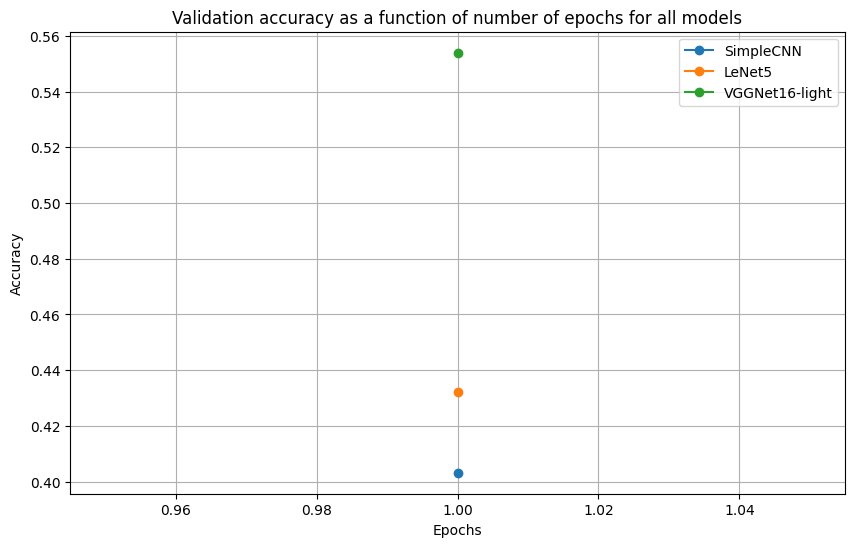


Training SimpleCNN...


KeyboardInterrupt: 

<Figure size 640x480 with 0 Axes>

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Training on device {device}.")
n_epochs=20
#Put in here the models you want to train
models = {
    #"VGGNet16":VGG16(), ---This network is to hard to compute for my laptop
    "SimpleCNN":SimpleCNN(),
   "LeNet5": LeNet5(),
   "VGGNet16-light":VGG16light(),
   
}
#models = {
#    "BcosLeNet5": BcosLeNet5(),
#    "LeNet5": LeNet5(),
    
#}

best_model, best_accuracy = model_selection_and_evaluation(models, train_loader, val_loader,n_epochs)
_,test_accuracy=validate(best_model, test_loader)*100.
print(f"\nBest model: {best_model.__class__.__name__} with a test accuracy of {test_accuracy:.2f}%")